In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymutspec.annotation import calculate_mutspec, CodonAnnotation, mutations_summary
from pymutspec.constants import possible_sbs192, possible_codons 
from scipy.spatial.distance import pdist, cdist, squareform, cosine

sns.set_style()

In [2]:
coda = CodonAnnotation(2)

## Load prepared mutations and reference

In [3]:
mutations = pd.read_csv("https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/processed/mutations.csv")
print(mutations.shape)
mutations.head()

(7611, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [4]:
Ref = pd.read_csv("https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/processed/ref_annot.csv")
print(Ref.shape)
Ref.head()

(16569, 10)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN


## Tissue/cancer type specific spectra

In [5]:
obs_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Label >= 0)
]
print(obs_all.shape)
obs_all.head()

(6340, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [6]:
ref_cur = Ref[(Ref.Type != "D-loop")].assign(AltNuc="ACGT")
ref_cur["AltNuc"] = ref_cur.AltNuc.apply(list)
ref_cur["AltCodon"] = ref_cur.apply(
    lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon >= 0 else [], axis=1)

exp_all = ref_cur.explode("AltNuc")
exp_all = exp_all[exp_all.Nuc != exp_all.AltNuc]
exp_all["Sbs12"] = exp_all.Nuc + ">" + exp_all.AltNuc
exp_all["Sbs192"] = exp_all.Context.str.get(0) + "[" + exp_all["Sbs12"] + "]" + exp_all.Context.str.get(-1)

exp_syn = ref_cur.explode("AltCodon").dropna(subset="AltCodon")
exp_syn["Sbs12"] = exp_syn.Nuc + ">" + exp_syn.apply(lambda x: x.AltCodon[x.PosInCodon-1], axis=1)
exp_syn["Sbs192"] = exp_syn.Context.str.get(0) + "[" + exp_syn["Sbs12"] + "]" + exp_syn.Context.str.get(-1)

exp_all_freqs = exp_all.Sbs192.value_counts().to_dict()
exp_syn_freqs = exp_syn.Sbs192.value_counts().to_dict()

In [7]:
exp_df = pd.Series(exp_all_freqs).rename('all').to_frame().join(
    pd.Series(exp_syn_freqs).rename('syn').to_frame())
exp_df['syn'] = exp_df['syn'].fillna(0.).astype(int)
exp_df['nonsyn'] = exp_df['all'] - exp_df['syn']
assert exp_df.nonsyn.min() > 0
exp_df

,all,syn,nonsyn
C[C>A]C,561,172,389
C[C>G]C,561,172,389
C[C>T]C,561,172,389
C[C>T]T,517,271,246
C[C>G]T,517,101,416
...,...,...,...
G[C>G]G,50,17,33
G[T>A]G,50,4,46
G[T>G]G,50,4,46
G[T>C]G,50,7,43


In [8]:
exp_nonsyn_freqs = exp_df['nonsyn'].to_dict()

In [9]:
tissue_mut_cnt = obs_all.tissue.value_counts()
tissue_mut_cnt = tissue_mut_cnt[tissue_mut_cnt > 100]
tissue_mut_cnt

Liver              1055
Pancreas            728
Kidney              651
Prostate            625
Breast              564
Ovary               351
Esophagus           338
Lymphoid            280
Lung                229
CNS                 220
Skin                186
Colon/Rectum        171
Stomach             168
Thyroid             140
Uterus              132
Bone/SoftTissue     125
Head/Neck           118
Name: tissue, dtype: int64

In [10]:
data = []

# first of all - full cancer spectrum (All tissues)
cur_obs_all = obs_all
cur_obs_syn = obs_all[(obs_all.Label > 0)]
cur_obs_nonsyn = obs_all[(obs_all.Label == 0)]
ms_all = calculate_mutspec(cur_obs_all, exp_all_freqs, use_context=True).assign(tissue='All tissues', muttype='all')
ms_syn = calculate_mutspec(cur_obs_syn, exp_syn_freqs, use_context=True).assign(tissue='All tissues', muttype='syn')
ms_nonsyn = calculate_mutspec(cur_obs_nonsyn, exp_nonsyn_freqs, use_context=True).assign(tissue='All tissues', muttype='nonsyn')
data.extend([ms_all, ms_syn, ms_nonsyn])

for tis in obs_all.tissue.unique():
    cur_obs_all = obs_all[obs_all.tissue == tis]
    cur_obs_syn = obs_all[(obs_all.tissue == tis) & (obs_all.Label > 0)]
    cur_obs_nonsyn = obs_all[(obs_all.tissue == tis) & (obs_all.Label == 0)]

    if len(cur_obs_all) < 130 or tis == 'Thyroid':
        continue
    
    # precomputed: 
        # exp_all_freqs
        # exp_syn_freqs
        # exp_nonsyn_freqs

    ms_all = calculate_mutspec(cur_obs_all, exp_all_freqs, use_context=True).assign(tissue=tis, muttype='all')
    ms_syn = calculate_mutspec(cur_obs_syn, exp_syn_freqs, use_context=True).assign(tissue=tis, muttype='syn')
    ms_nonsyn = calculate_mutspec(cur_obs_nonsyn, exp_nonsyn_freqs, use_context=True).assign(tissue=tis, muttype='nonsyn')

    data.extend([ms_all, ms_syn, ms_nonsyn])

In [11]:
spectra_tissue_specific = pd.concat(data, ignore_index=True)
spectra_tissue_specific.to_csv('../data/human_cancer_spectra_tissue_specific.csv', index=False)
spectra_tissue_specific

,Mut,ObsNum,ExpNum,MutSpec,tissue,muttype
0,A[A>C]C,15,463.0,0.000837,All tissues,all
1,A[A>C]G,1,196.0,0.000132,All tissues,all
2,A[A>C]T,1,355.0,0.000073,All tissues,all
3,A[A>G]A,9,494.0,0.000471,All tissues,all
4,A[A>G]C,79,463.0,0.004409,All tissues,all
...,...,...,...,...,...,...
8635,C[G>T]A,0,110.0,0.000000,Skin,nonsyn
8636,C[T>A]A,0,435.0,0.000000,Skin,nonsyn
8637,C[C>G]A,0,265.0,0.000000,Skin,nonsyn
8638,T[C>A]A,0,318.0,0.000000,Skin,nonsyn


In [9]:
# spectra_tissue_specific = pd.read_csv('../data/human_cancer_spectra_tissue_specific.csv')
# spectra_tissue_specific

In [12]:
spectra_tissue_specific_wide = spectra_tissue_specific.pivot(['tissue', 'muttype'], 'Mut', 'MutSpec')
print(spectra_tissue_specific_wide.shape)
spectra_tissue_specific_wide.head()

(45, 192)


Mut                  A[A>C]A   A[A>C]C   A[A>C]G   A[A>C]T   A[A>G]A  \
tissue      muttype                                                    
All tissues all          0.0  0.000837  0.000132  0.000073  0.000471   
            nonsyn       0.0  0.000839  0.000132  0.000073  0.000498   
            syn          0.0  0.000000  0.000000  0.000000  0.000339   
Breast      all          0.0  0.002032  0.000000  0.000000  0.000000   
            nonsyn       0.0  0.002034  0.000000  0.000000  0.000000   

Mut                   A[A>G]C   A[A>G]G   A[A>G]T   A[A>T]A   A[A>T]C  ...  \
tissue      muttype                                                    ...   
All tissues all      0.004409  0.001319  0.002184  0.000628  0.000223  ...   
            nonsyn   0.004858  0.001234  0.002105  0.000629  0.000224  ...   
            syn      0.001680  0.001620  0.003024  0.000000  0.000000  ...   
Breast      all      0.008128  0.003200  0.003534  0.000635  0.000000  ...   
            nonsyn   0.008635  0.000000  0.003925  0.000636  0.000000  ...   

Mut                  T[T>A]G  T[T>A]T   T[T>C]A   T[T>C]C   T[T>C]G   T[T>C]T  \
tissue      muttype                                                             
All tissues all          0.0      0.0  0.006897  0.009790  0.009939  0.008279   
            nonsyn       0.0      0.0  0.006037  0.010578  0.010100  0.008871   
            syn          0.0      0.0  0.008820  0.007762  0.009996  0.006193   
Breast      all          0.0      0.0  0.015126  0.011774  0.012062  0.010861   
            nonsyn       0.0      0.0  0.015242  0.014403  0.010644  0.013652   

Mut                  T[T>G]A  T[T>G]C   T[T>G]G  T[T>G]T  
tissue      muttype                                       
All tissues all          0.0      0.0  0.000745      0.0  
            nonsyn       0.0      0.0  0.000000      0.0  
            syn          0.0      0.0  0.007217      0.0  
Breast      all          0.0      0.0  0.000000      0.0  
            nonsyn       0.0      0.0  0.000000      0.0  

[5 rows x 192 columns]

## Compare all ans syn by cossim

In [13]:
tissues_lst = list(spectra_tissue_specific.tissue.unique())
print("Used tissues:")
print(tissues_lst)

data_compare_all_syn = []
for t in tissues_lst:
    sp = spectra_tissue_specific_wide.loc[t]
    if len(sp) == 1:
        continue
    pairwise_cossims = 1 - pdist(sp, 'cosine')
    cossim_all_vs_nonsyn = pairwise_cossims[0]
    cossim_all_vs_syn = pairwise_cossims[1]
    cossim_nonsyn_vs_syn = pairwise_cossims[2]

    # cossim on reduced spectra
    pairwise_cossims_red = 1 - pdist(sp.loc[:, ~(sp == 0).any(axis=0)], 'cosine')
    cossim_all_vs_nonsyn_red = pairwise_cossims_red[0]
    cossim_all_vs_syn_red = pairwise_cossims_red[1]
    cossim_nonsyn_vs_syn_red = pairwise_cossims_red[2]

    # num of observed mutations
    if t == 'All tissues':
        nobs_all = obs_all[(obs_all.Label >= 0)].shape[0]
        nobs_nonsyn = obs_all[(obs_all.Label == 0)].shape[0]
        nobs_syn = obs_all[(obs_all.Label >= 1)].shape[0]
    else:
        nobs_all = obs_all[(obs_all.tissue == t) & (obs_all.Label >= 0)].shape[0]
        nobs_nonsyn = obs_all[(obs_all.tissue == t) & (obs_all.Label == 0)].shape[0]
        nobs_syn = obs_all[(obs_all.tissue == t) & (obs_all.Label >= 1)].shape[0]

    # 
    nmuttypes = (sp != 0).sum(axis=1)

    data_compare_all_syn.append([
        t, 
        cossim_all_vs_nonsyn, cossim_all_vs_nonsyn_red, 
        cossim_all_vs_syn, cossim_all_vs_syn_red, 
        cossim_nonsyn_vs_syn, cossim_nonsyn_vs_syn_red, 
        nobs_all, nmuttypes.loc['all'], 
        nobs_nonsyn, nmuttypes.loc['nonsyn'],
        nobs_syn, nmuttypes.loc['syn'],
    ])

Used tissues:
['All tissues', 'Pancreas', 'Esophagus', 'Liver', 'Breast', 'Colon/Rectum', 'Prostate', 'Kidney', 'Lung', 'Ovary', 'Lymphoid', 'Uterus', 'CNS', 'Stomach', 'Skin']


In [14]:
_cols = [
    'tissue', 
    'cossim_all_vs_nonsyn', 'cossim_all_vs_nonsyn_red', 
    'cossim_all_vs_syn', 'cossim_all_vs_syn_red', 
    'cossim_nonsyn_vs_syn', 'cossim_nonsyn_vs_syn_red', 
    'nobs_all', 'nmuttypes_all', 
    'nobs_nonsyn', 'nmuttypes_nonsyn',
    'nobs_syn', 'nmuttypes_syn',
]
df_compare_all_syn = pd.DataFrame(
    data_compare_all_syn, columns=_cols)#.sort_values('cossim', ascending=False)
df_compare_all_syn.to_csv('../data/human_cancer_spectra_all_vs_syn.csv', index=False, float_format='%g')
df_compare_all_syn

,tissue,cossim_all_vs_nonsyn,cossim_all_vs_nonsyn_red,cossim_all_vs_syn,cossim_all_vs_syn_red,cossim_nonsyn_vs_syn,cossim_nonsyn_vs_syn_red,nobs_all,nmuttypes_all,nobs_nonsyn,nmuttypes_nonsyn,nobs_syn,nmuttypes_syn
0,All tissues,0.999147,0.999183,0.934303,0.937350,0.921317,0.924822,6340,160,5505,155,835,93
1,Pancreas,0.993866,0.992785,0.715208,0.811448,0.655473,0.749127,728,93,640,90,88,49
2,Esophagus,0.989403,0.988747,0.581563,0.775982,0.476636,0.690772,338,77,287,71,51,34
3,Liver,0.996541,0.997302,0.867749,0.875287,0.835763,0.846266,1055,95,919,88,136,58
4,Breast,0.991898,0.990356,0.587079,0.773527,0.508906,0.707461,564,88,487,77,77,42
5,Colon/Rectum,0.984658,0.982074,0.556351,0.860939,0.431612,0.779678,171,58,146,54,25,21
6,Prostate,0.997014,0.996722,0.689012,0.800677,0.638471,0.753808,625,70,559,63,66,37
7,Kidney,0.994102,0.994661,0.802461,0.831705,0.744520,0.778485,651,97,560,93,91,50
8,Lung,0.995049,0.991863,0.516689,0.908354,0.440385,0.852831,229,53,202,51,27,19
9,Ovary,0.992683,0.994503,0.585387,0.785257,0.506074,0.725779,351,70,309,60,42,32


In [16]:
[x for x in df_compare_all_syn.columns if 'nonsyn' not in x and x != 'tissue']

['cossim_all_vs_syn',
 'cossim_all_vs_syn_red',
 'nobs_all',
 'nmuttypes_all',
 'nobs_syn',
 'nmuttypes_syn']

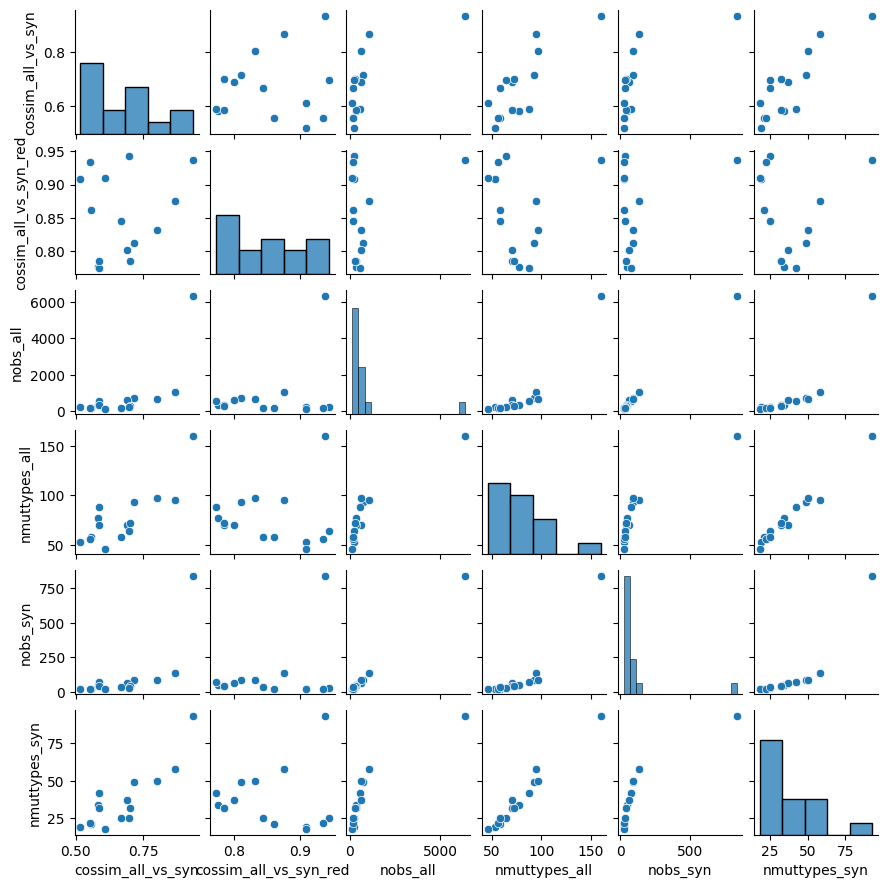

In [53]:
sns.pairplot(
    df_compare_all_syn\
        .loc[:, [x for x in df_compare_all_syn.columns if 'nonsyn' not in x and x != 'tissue']], 
    size=1.5)

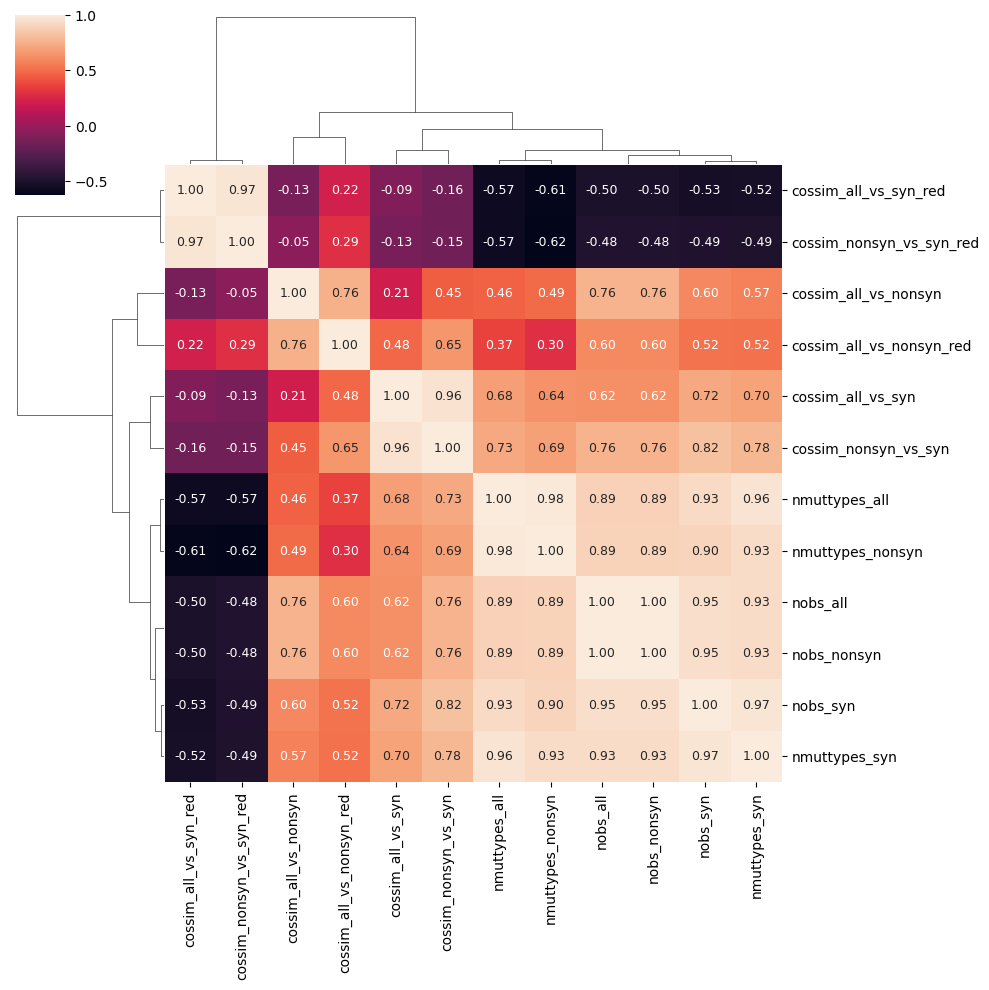

In [54]:
sns.clustermap(df_compare_all_syn.iloc[1:].corr('spearman'), annot=True, fmt='.2f', figsize=(10,10), annot_kws={'fontsize': 9})

# Compare all vs all

In [21]:
def cosine_red(u, v):
    nonzeros = [(u > 0) & (v > 0)]
    d = cosine(u[nonzeros], v[nonzeros])
    return d

In [18]:
# df_compare_all_syn = pd.read_csv('../data/human_cancer_spectra_all_vs_syn.csv')
# df_compare_all_syn

#### Clustermups: syn vs nonsyn

Common cosine distance: syn vs nonsyn


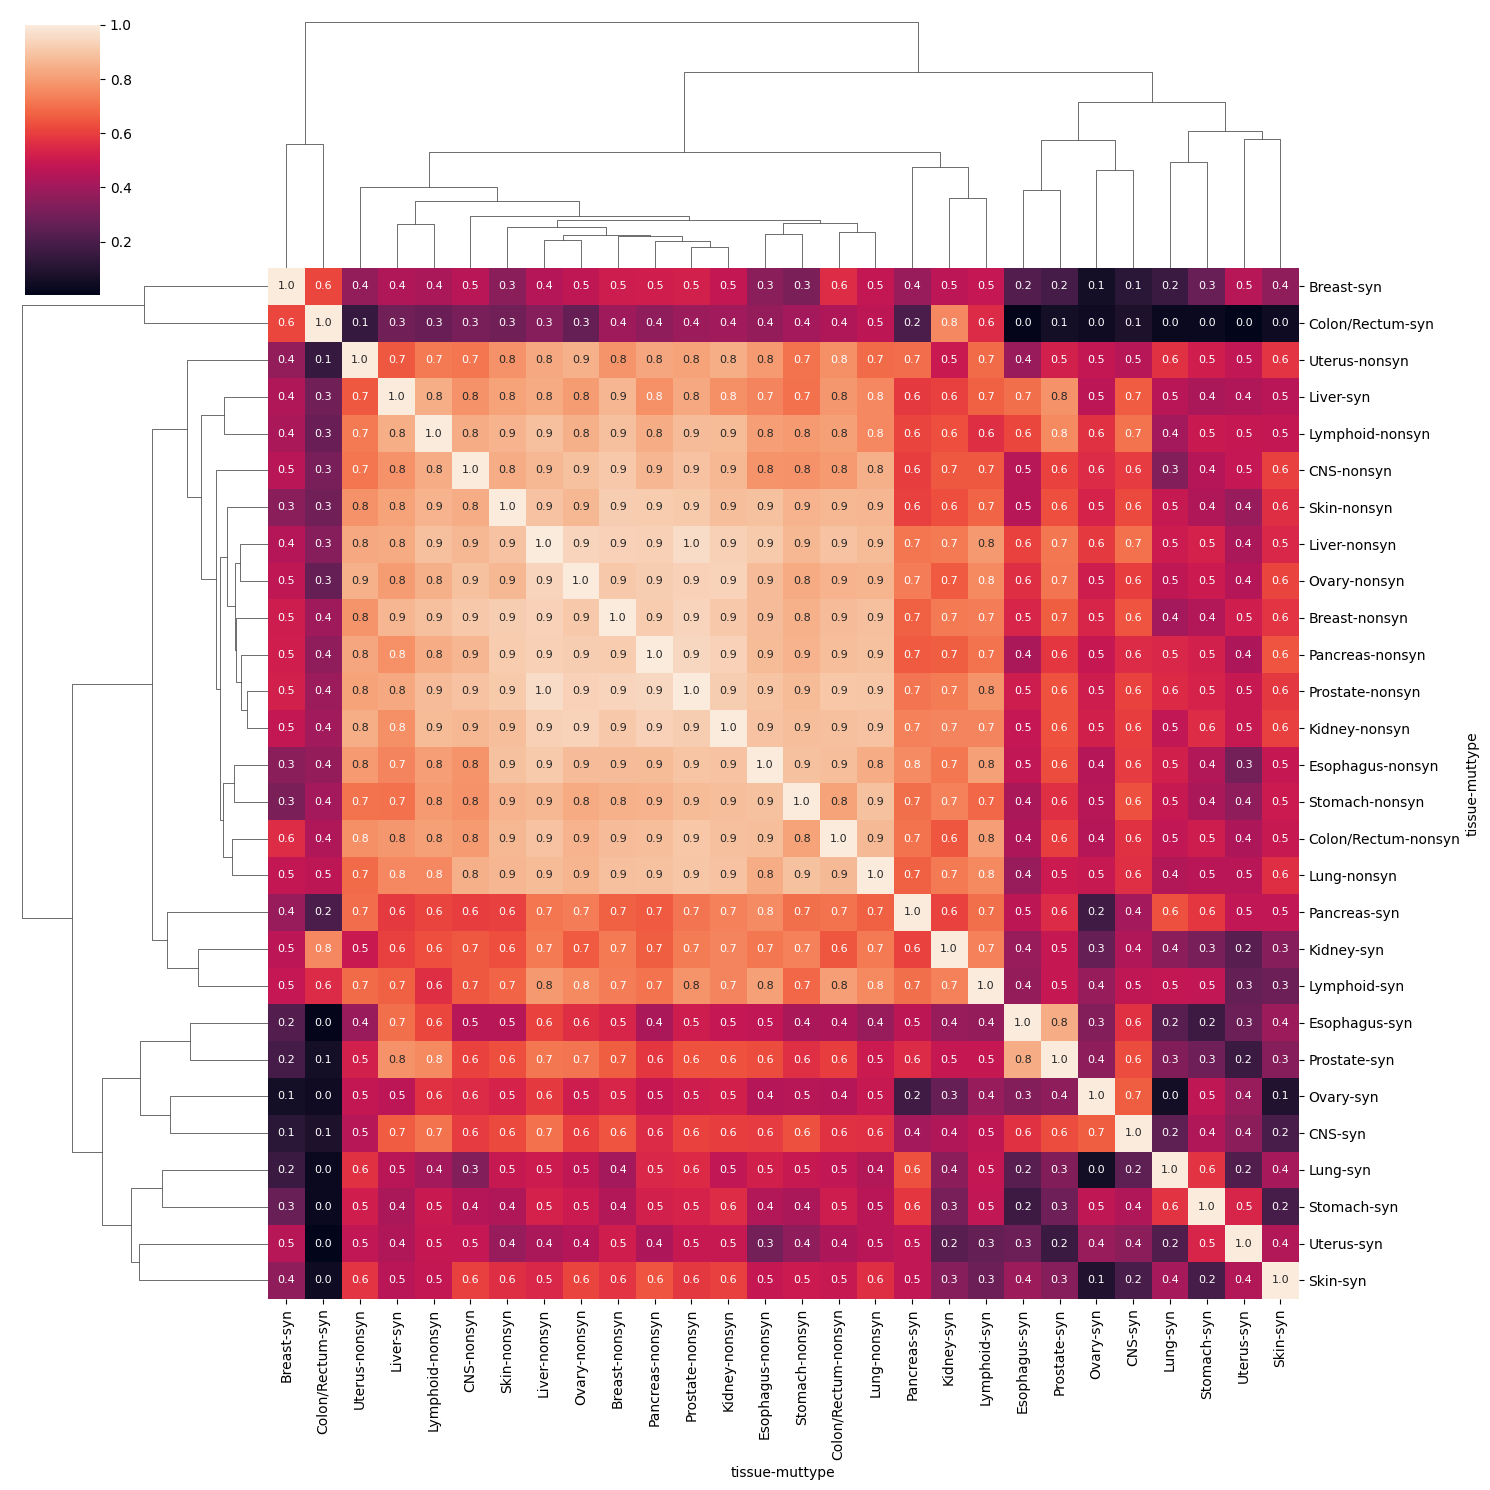

In [28]:
_x = spectra_tissue_specific_wide[
    spectra_tissue_specific_wide.index.get_level_values(1) != 'all'
].loc[df_compare_all_syn.tissue.values[1:]]

d = pd.DataFrame(1 - squareform(pdist(_x, 'cosine')), columns=_x.index, index=_x.index)
g = sns.clustermap(d, figsize=(15, 15), annot=True, fmt='.1f', annot_kws={'fontsize': 8})
print('Common cosine distance: syn vs nonsyn')

Reduced cosine distance: syn vs nonsyn


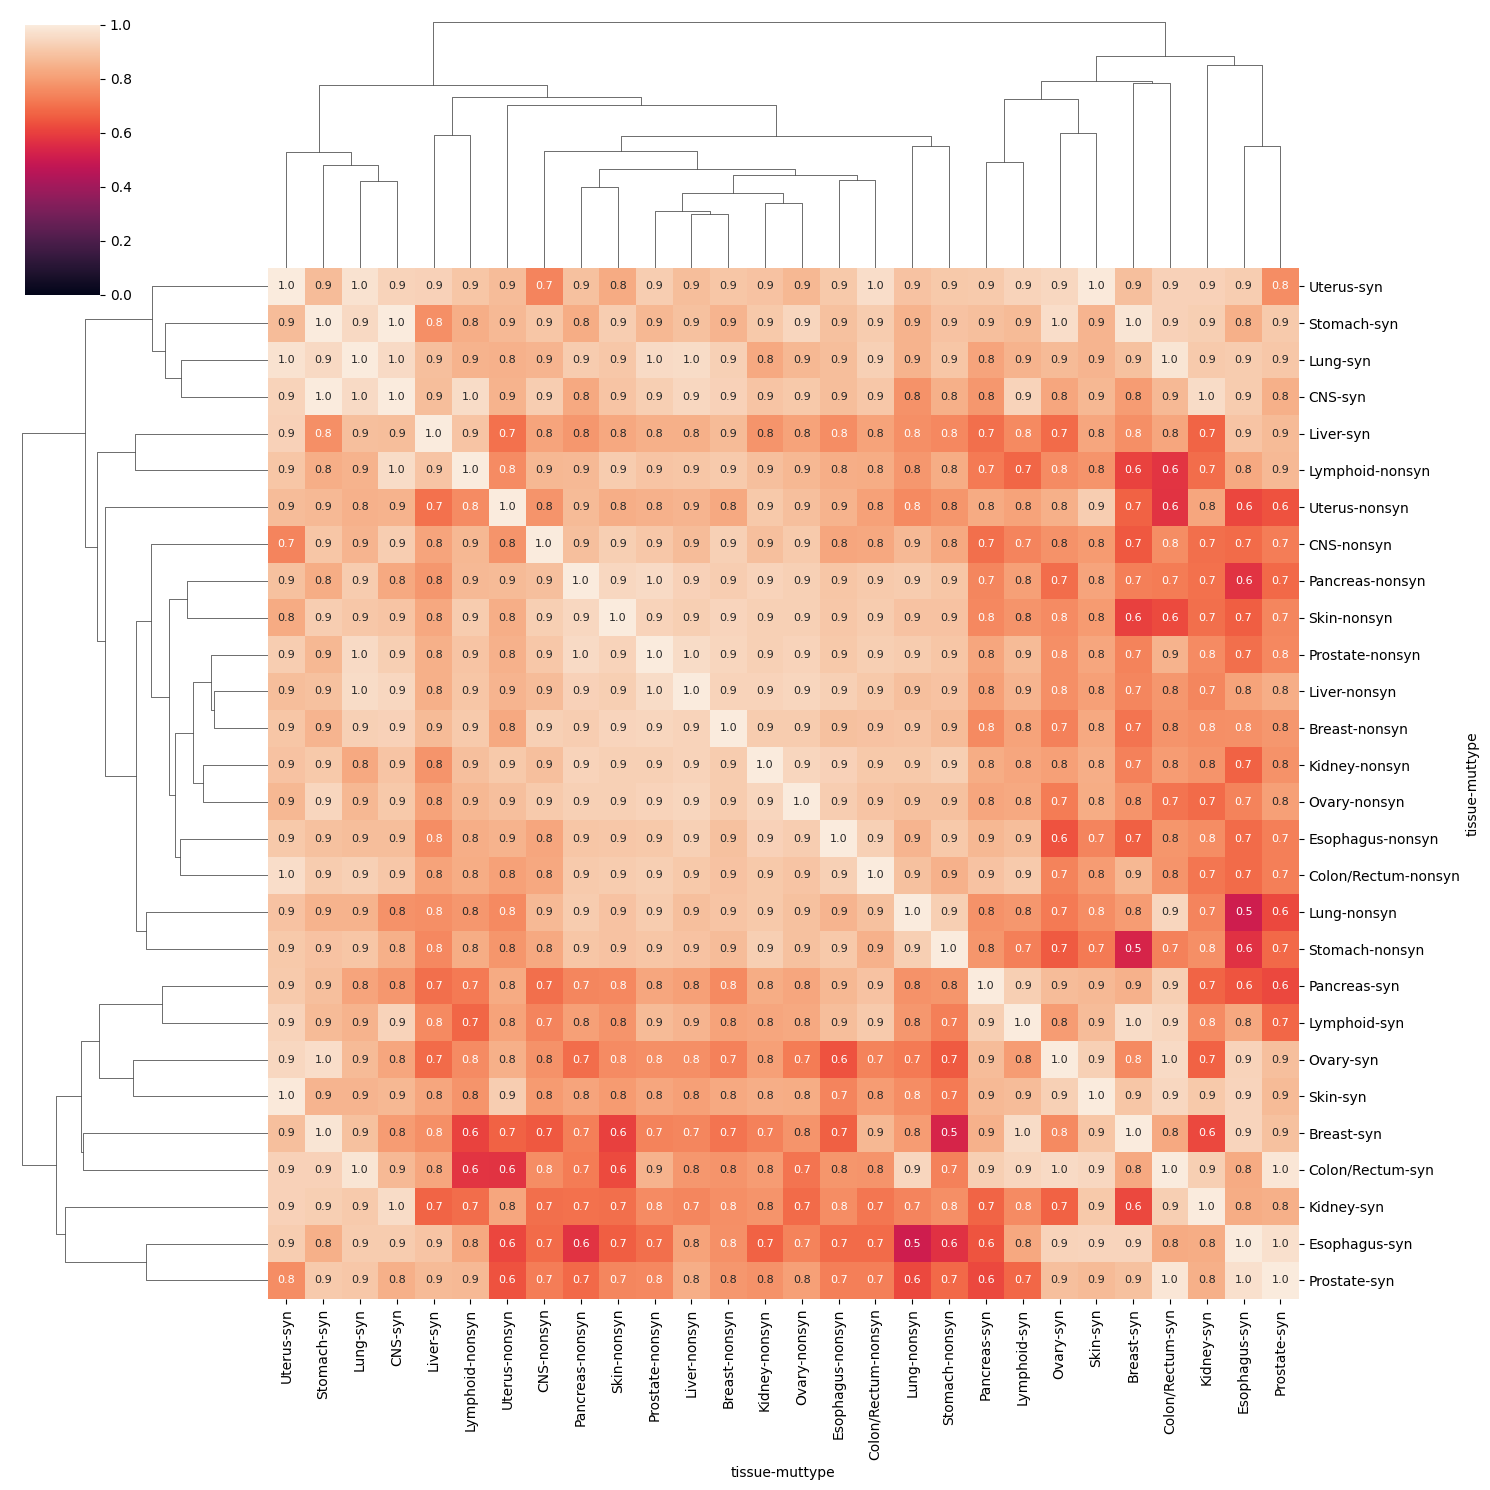

In [30]:
_x = spectra_tissue_specific_wide[
    spectra_tissue_specific_wide.index.get_level_values(1) != 'all'
].loc[df_compare_all_syn.tissue.values[1:]]

d = pd.DataFrame(1 - squareform(pdist(_x, cosine_red)), columns=_x.index, index=_x.index)
g = sns.clustermap(d, figsize=(15, 15), annot=True, fmt='.1f', annot_kws={'fontsize': 8}, vmin=0)
print('Reduced cosine distance: syn vs nonsyn')

#### Heatmaps

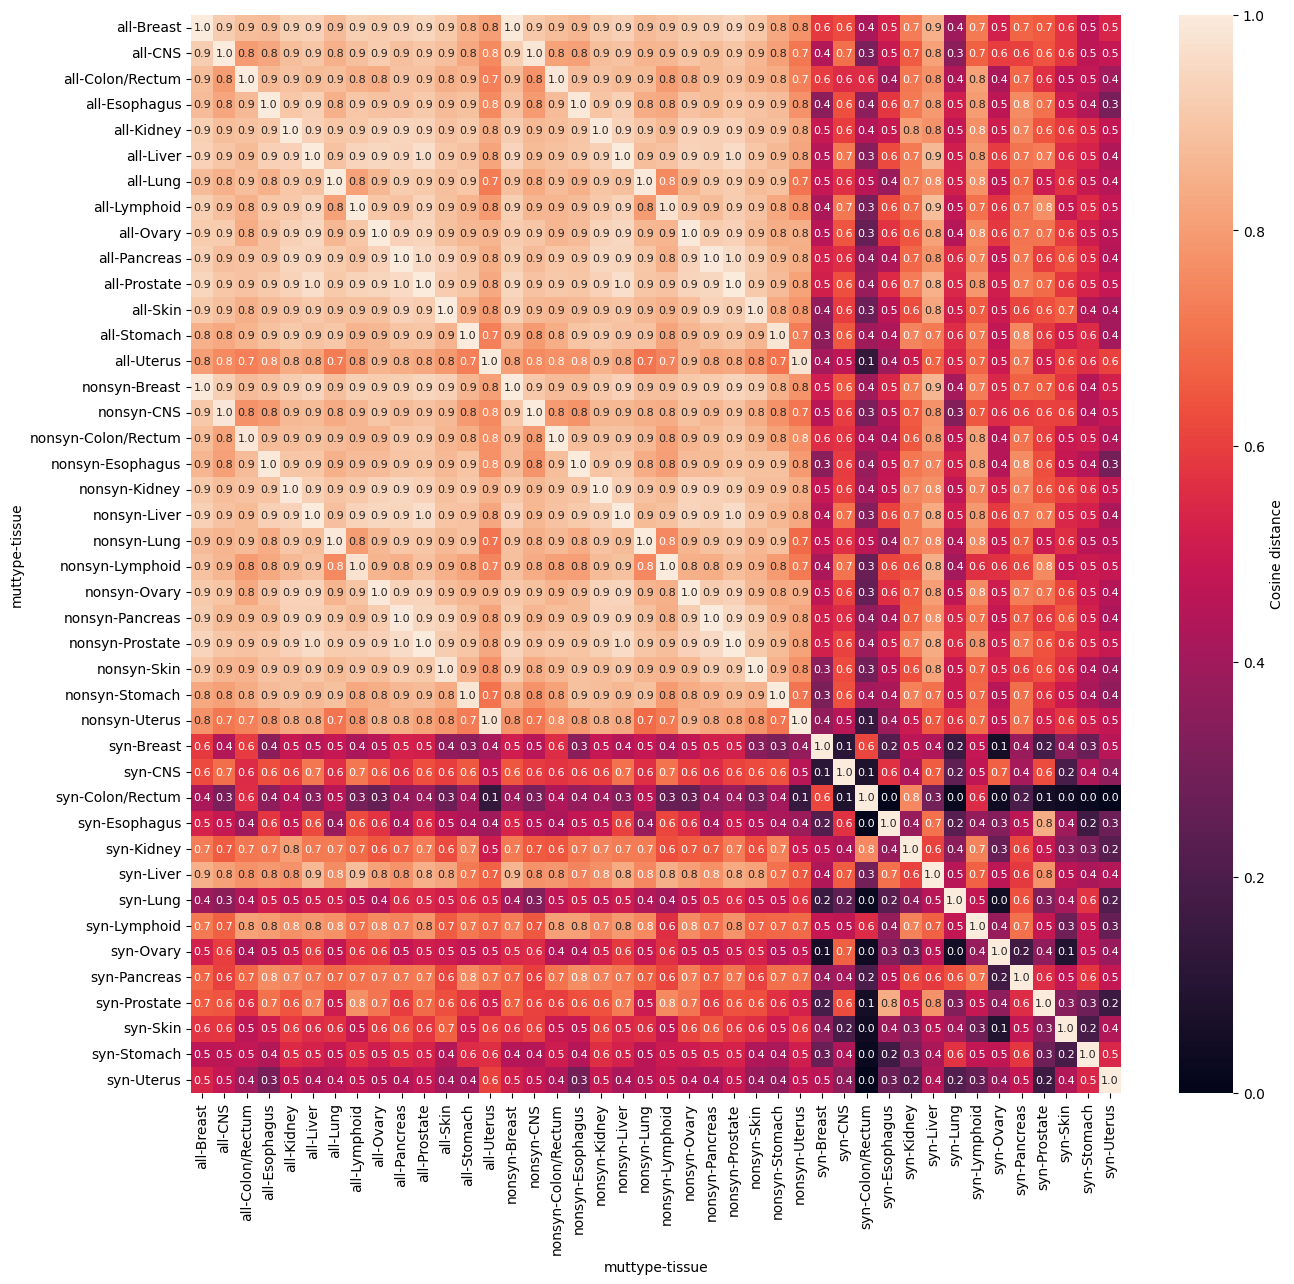

In [93]:
plt.figure(figsize=(15, 14))

_x = spectra_tissue_specific_wide.loc[df_compare_all_syn.tissue.values[1:]]
_x.index = _x.index.reorder_levels([1,0])
_x = _x.sort_index()


d = pd.DataFrame(1 - squareform(pdist(_x, 'cosine')), columns=_x.index, index=_x.index)

ax = sns.heatmap(d, annot=True, fmt='.1f', annot_kws={'fontsize': 8}, vmin=0.,
            cbar_kws={'label': 'Cosine distance'})

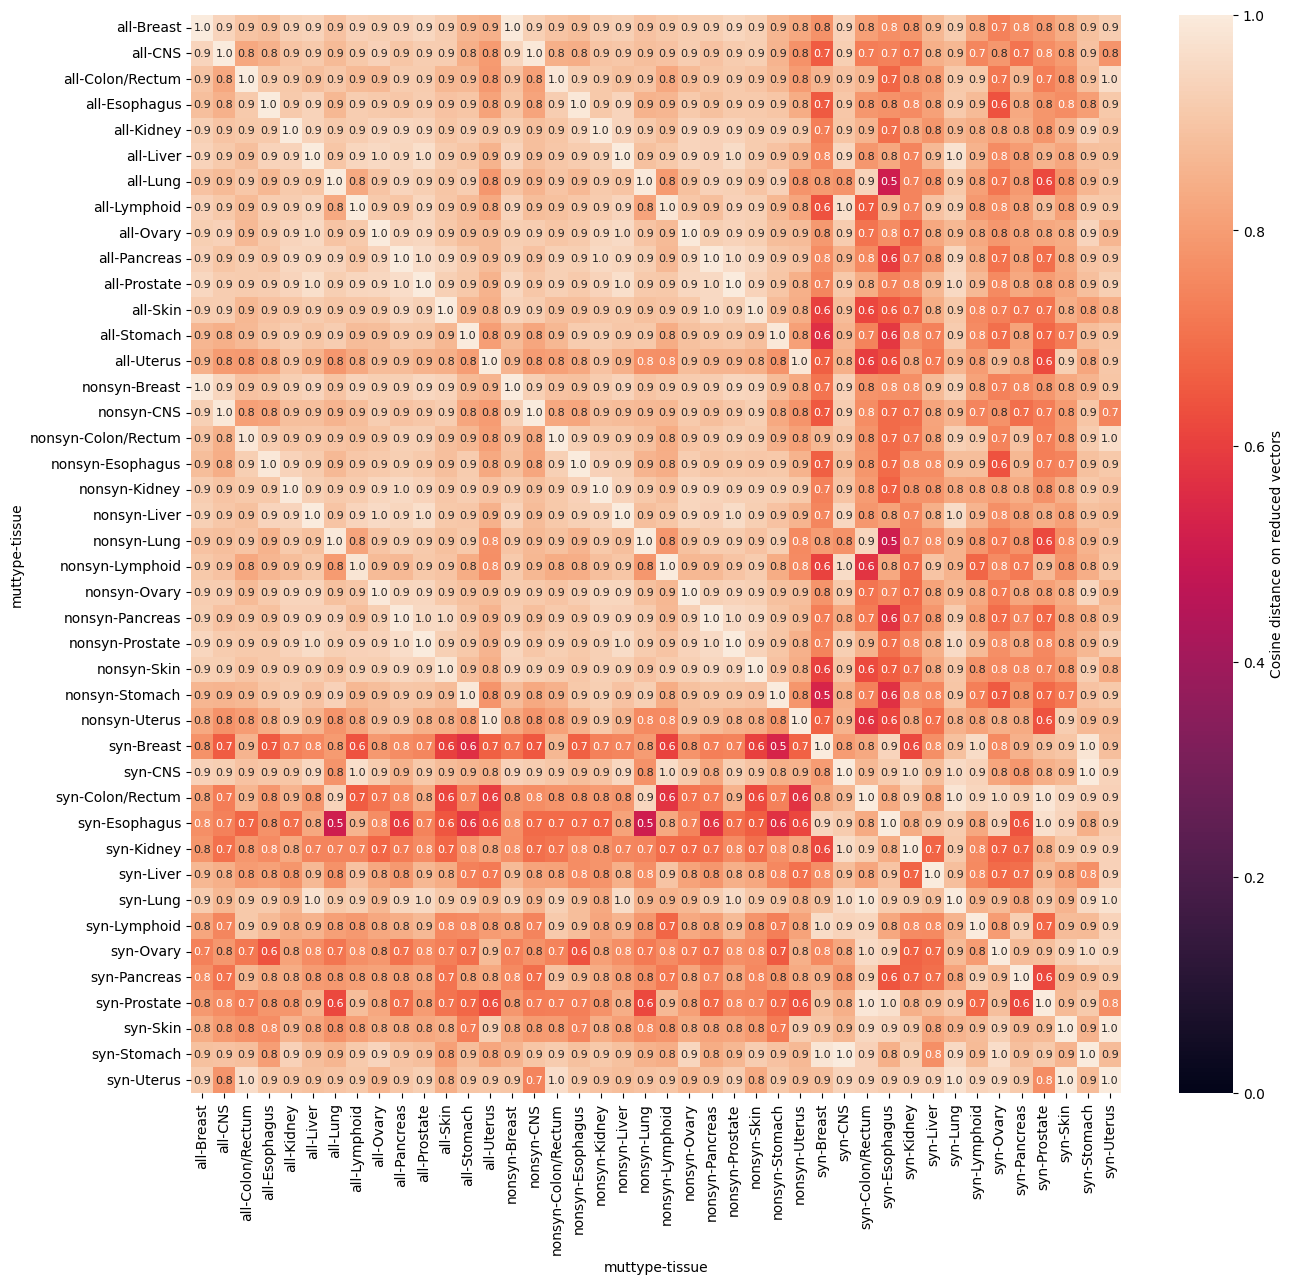

In [92]:
plt.figure(figsize=(15, 14))

_x = spectra_tissue_specific_wide.loc[df_compare_all_syn.tissue.values[1:]]
_x.index = _x.index.reorder_levels([1,0])
_x = _x.sort_index()


d = pd.DataFrame(1 - squareform(pdist(_x, cosine_red)), columns=_x.index, index=_x.index)

ax = sns.heatmap(d, annot=True, fmt='.1f', annot_kws={'fontsize': 8}, vmin=0.,
                 cbar_kws={'label': 'Cosine distance on reduced vectors'})

#### Only syn heatmaps

In [41]:
# number of zeroes in syn spectra
(spectra_tissue_specific_wide > 0).sum(axis=1).unstack()

muttype,all,nonsyn,syn
tissue,,,
All tissues,160,155,93
Breast,88,77,42
CNS,64,53,25
Colon/Rectum,58,54,21
Esophagus,77,71,34
Kidney,97,93,50
Liver,95,88,58
Lung,53,51,19
Lymphoid,72,64,32


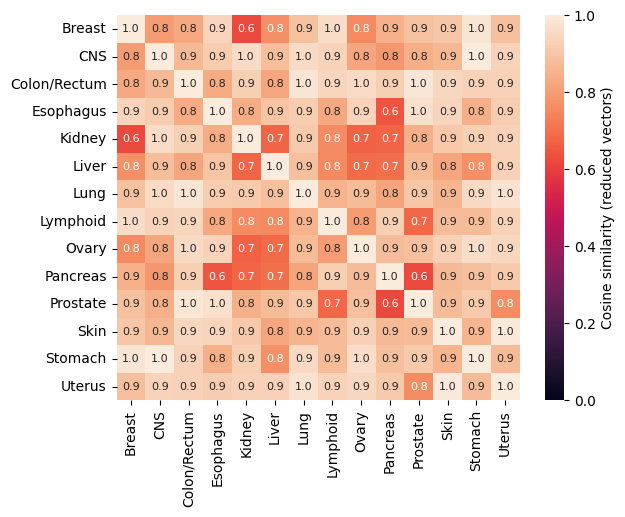

In [52]:
plt.figure(figsize=(6.5, 5))

x = spectra_tissue_specific_wide.reset_index(level=1)
x = x[x.muttype == 'syn'].drop('muttype', axis=1)

_x = x.loc[df_compare_all_syn.tissue.values[1:]]
_x = _x.sort_index()


d = pd.DataFrame(1 - squareform(pdist(_x, cosine_red)), columns=_x.index, index=_x.index)

ax = sns.heatmap(d, annot=True, fmt='.1f', annot_kws={'fontsize': 8}, vmin=0.,
            cbar_kws={'label': 'Cosine similarity (reduced vectors)'})
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('../pictures/human_cancer_tissue_vs_tissue_syn.pdf', bbox_inches='tight')

## Try to vizualize `all vs syn` spectra on one plot

### PCA - bad

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming your dataframe is stored in the variable spectra_tissue_specific_wide

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectra_tissue_specific_wide.iloc[2:])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a new dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Get the variance share of each principal component
variance_ratio = pca.explained_variance_ratio_
variance_share_pc1 = round(variance_ratio[0]*100, 2)
variance_share_pc2 = round(variance_ratio[1]*100, 2)

pca_df['tissue'] = spectra_tissue_specific_wide.index.get_level_values(0)[2:]
pca_df['muttype'] = spectra_tissue_specific_wide.index.get_level_values(1)[2:]
pca_df.head()

,PC1,PC2,tissue,muttype
0,-2.450471,-1.091017,All tissues,syn
1,4.842026,-2.304461,Breast,all
2,5.803331,-2.402925,Breast,nonsyn
3,-3.315266,-1.390047,Breast,syn
4,4.531162,8.649953,CNS,all


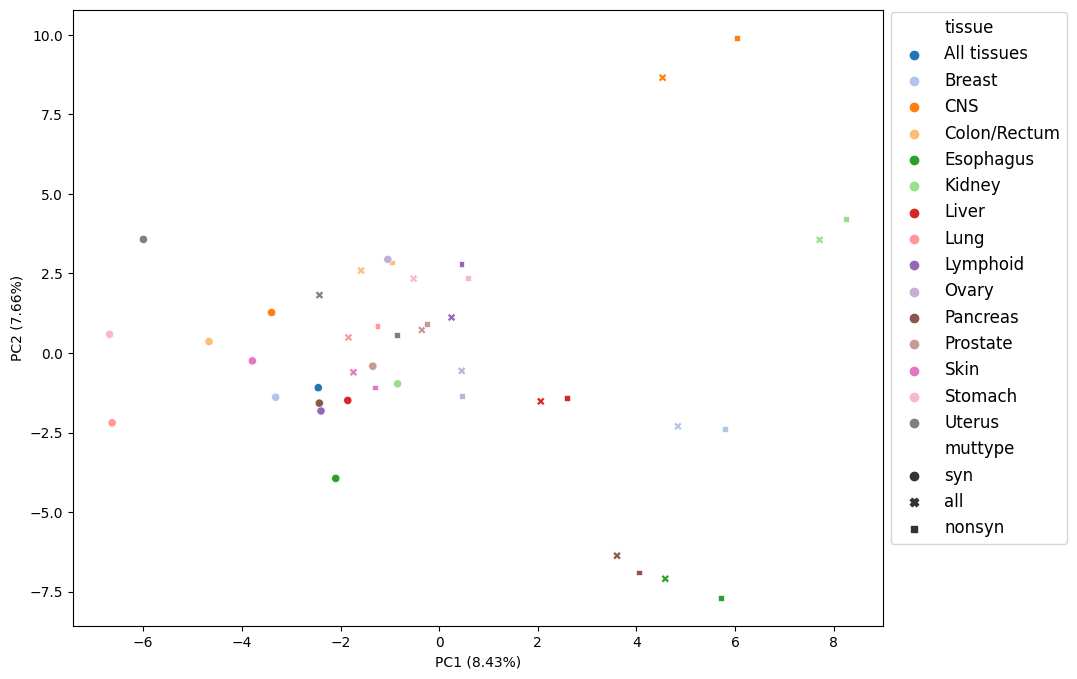

In [54]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='tissue', style='muttype', palette='tab20')
# ax.set_xlim(-10.5, 8)
ax.set_xlabel(f'PC1 ({variance_share_pc1}%)')
ax.set_ylabel(f'PC2 ({variance_share_pc2}%)')

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend

plt.show()

### UMAP - nice

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectra_tissue_specific_wide.iloc[2:])

# Create UMAP instance and fit the data
umap_instance = umap.UMAP(n_neighbors=3, n_components=2, metric='cosine',  random_state=777)#, learning_rate=2., n_epochs=100000)
umap_result = umap_instance.fit_transform(scaled_data)

# Create a new dataframe with the UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['tissue'] = spectra_tissue_specific_wide.index.get_level_values(0)[2:]
umap_df['muttype'] = spectra_tissue_specific_wide.index.get_level_values(1)[2:]

# add cool labels
t2tlabel = dict(df_compare_all_syn.apply(lambda x: (x.tissue, f"{x.tissue} ({x.cossim_all_vs_syn:.2f}, {x.cossim_all_vs_syn_red:.2f})"), axis=1).values)
umap_df['tissue_label'] = umap_df['tissue'].map(t2tlabel)

umap_df.head()

,UMAP1,UMAP2,tissue,muttype,tissue_label
0,2.118537,6.041105,All tissues,syn,"All tissues (0.93, 0.94)"
1,1.665911,5.137174,Breast,all,"Breast (0.59, 0.77)"
2,1.532445,4.859886,Breast,nonsyn,"Breast (0.59, 0.77)"
3,1.867724,5.564805,Breast,syn,"Breast (0.59, 0.77)"
4,3.099660,3.251522,CNS,all,"CNS (0.70, 0.94)"


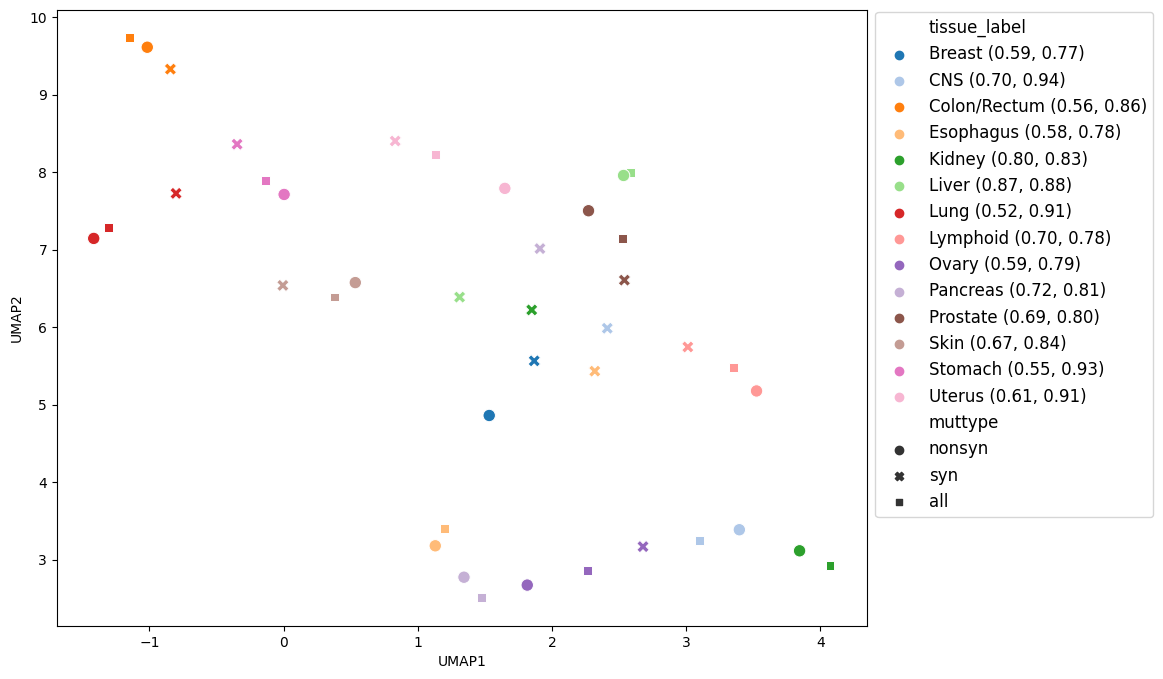

In [73]:
# Visualize the UMAP results
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=umap_df.iloc[2:], x='UMAP1', y='UMAP2', hue='tissue_label', 
    style='muttype', palette='tab20', s=80,
)

# Move the legend outside of the plot to the right
legend = ax.legend(bbox_to_anchor=(1, 1.01), loc='upper left', fontsize=12)
plt.subplots_adjust(right=0.8)  # Adjust the right margin to make space for the legend
plt.savefig('../pictures/human_cancer_spectra_tissues_umap.pdf')
plt.show()